<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Project/AE_mnist_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE for style transfer via CINN

Training a common AE for the coloured mnist and uncoloured mnist dataset

Let's first generate the coloured MNIST dataset

In [ ]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
np.random.randint(0,256,3)

array([162,  11, 119])

### 1. Colored images (combination of R,G,B (and not just one of R,G,B))

(For coloring the digits only either red or green or blue, go to section 2 in the notebook below)

In [ ]:
# Function to randomly colorize MNIST dataset
def random_colorize_mnist(X):
    colored_X = np.zeros((X.shape[0], X.shape[1], X.shape[2], 3), dtype=np.uint8)

    for i in range(X.shape[0]):
        img = X[i]

        # Generate random color
        color = np.random.randint(0, 256, 3)

        # Colorize the digits while keeping the background unchanged
        colored_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        colored_img[img > 0] = color
        colored_X[i] = colored_img

    return colored_X

In [ ]:
# Load MNIST training dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()

# Load MNIST test dataset
test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

100%|██████████| 9912422/9912422 [00:00<00:00, 90546736.66it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42119504.11it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26942162.25it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20843029.29it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Colorize the training images
colored_X_train = random_colorize_mnist(X_train)

# Colorize the test images
colored_X_test = random_colorize_mnist(X_test)

In [ ]:
# Function to plot colored MNIST dataset
def plotting_mnist_dataset(colored_X, title):
    plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(colored_X[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

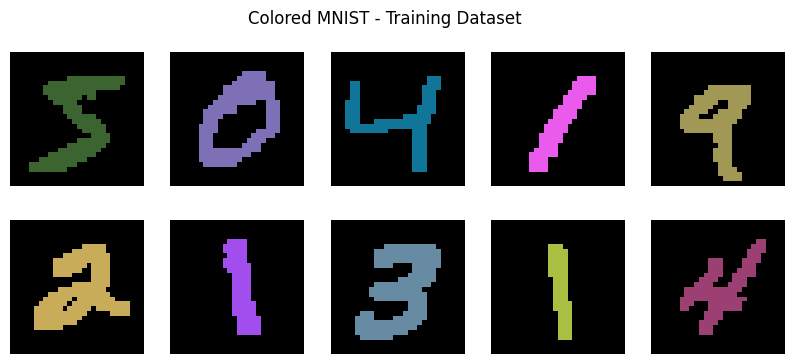

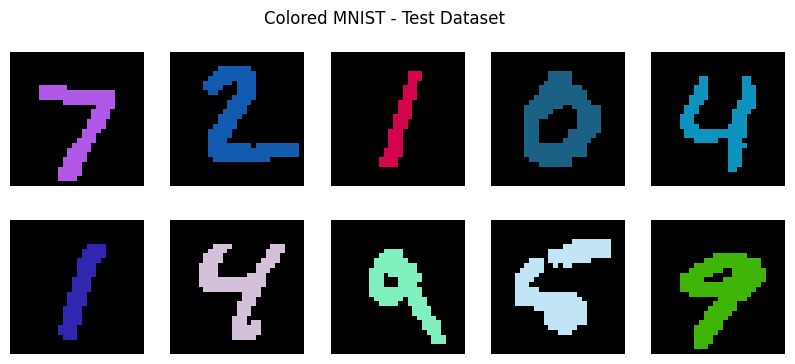

In [ ]:
# Plot colored images from the training dataset
plotting_mnist_dataset(colored_X_train, 'Colored MNIST - Training Dataset')

# Plot colored images from the test dataset
plotting_mnist_dataset(colored_X_test, 'Colored MNIST - Test Dataset')

In [ ]:
# Save colored datasets and labels
np.savez('colored_mnist_train.npz', images=colored_X_train, labels=y_train)
np.savez('colored_mnist_test.npz', images=colored_X_test, labels=y_test)

In [ ]:
# #  CODE TO Load the colored training dataset
# train_data = np.load('colored_mnist_train.npz')
# colored_X_train = train_data['images']
# y_train = train_data['labels']

# # Load the colored test dataset
# test_data = np.load('colored_mnist_test.npz')
# colored_X_test = test_data['images']
# y_test = test_data['labels']

### 2. Let's create the dataset where the digits are colored only R,G,B.

In [ ]:
# Function to randomly colorize MNIST dataset with a single color channel
def random_colorize_rgb_mnist(X):
    colored_X = np.zeros((X.shape[0], X.shape[1], X.shape[2], 3), dtype=np.uint8)

    for i in range(X.shape[0]):
        img = X[i]

        # Generate random color channel index (0 for red, 1 for green, 2 for blue)
        color_channel_index = np.random.randint(0, 3)

        # Set the color based on the selected color channel
        color = [0, 0, 0]
        color[color_channel_index] = 255

        # Colorize the digits while keeping the background unchanged
        colored_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        colored_img[img > 0] = color
        colored_X[i] = colored_img

    return colored_X


In [ ]:
colored_rgb_X_train = random_colorize_rgb_mnist(X_train)
colored_rgb_X_test = random_colorize_rgb_mnist(X_test)

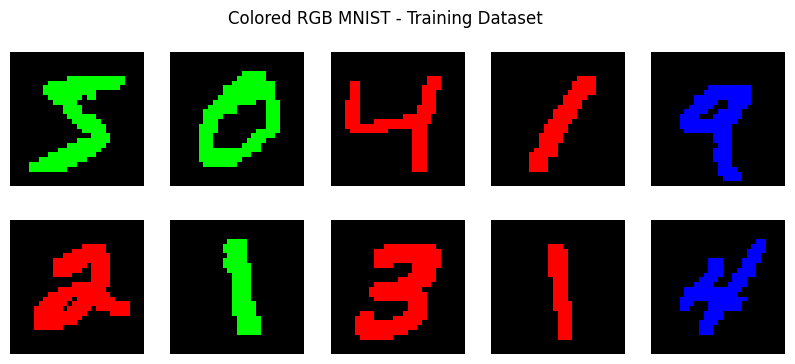

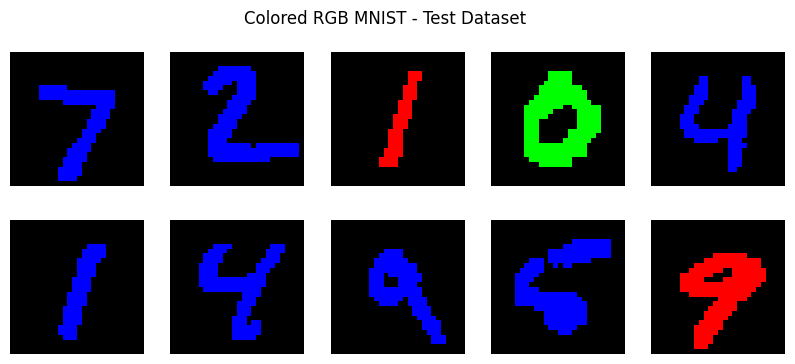

In [ ]:
# Plot colored images from the training dataset
plotting_mnist_dataset(colored_rgb_X_train, 'Colored RGB MNIST - Training Dataset')

# Plot colored images from the test dataset
plotting_mnist_dataset(colored_rgb_X_test, 'Colored RGB MNIST - Test Dataset')

In [ ]:
# Save colored datasets and labels
np.savez('colored_rgb_mnist_train.npz', images=colored_X_train, labels=y_train)
np.savez('colored_rgb_mnist_test.npz', images=colored_X_test, labels=y_test)

### Creating the dataset for AE training:

In [ ]:
### Load MNIST training dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
uncolored_X_train = train_dataset.data.numpy()
uncolored_y_train = train_dataset.targets.numpy()

### Load MNIST test dataset
test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())
uncolored_X_test = test_dataset.data.numpy()
uncolored_y_test = test_dataset.targets.numpy()

### coloured dataset
colored_rgb_X_train = random_colorize_rgb_mnist(uncolored_X_train)
colored_rgb_X_test = random_colorize_rgb_mnist(uncolored_X_test)

### labels for the dataset
# Create labels for uncolored datasets
uncolored_labels_train = np.zeros(len(uncolored_X_train))
uncolored_labels_test = np.zeros(len(uncolored_X_test))

# Create labels for colored datasets
colored_labels_train = np.ones(len(colored_rgb_X_train))
colored_labels_test = np.ones(len(colored_rgb_X_test))

In [ ]:
np.shape(uncolored_X_train), np.shape(colored_rgb_X_train)

((60000, 28, 28), (60000, 28, 28, 3))

Expanding the single-channel images of the uncolored dataset to three channels by replicating the single channel across all three channels:

In [ ]:
# Reshape uncolored images to (60000, 28, 28, 1)
uncolored_X_train_resized = uncolored_X_train.reshape(-1, 28, 28, 1)
uncolored_X_test_resized = uncolored_X_test.reshape(-1, 28, 28, 1)

# Expand single channel to three channels
uncolored_X_train_expanded = np.repeat(uncolored_X_train_resized, 3, axis=-1)
uncolored_X_test_expanded = np.repeat(uncolored_X_test_resized, 3, axis=-1)

In [ ]:
np.shape(uncolored_X_train), np.shape(colored_rgb_X_train), np.shape(uncolored_X_train_expanded)

((60000, 28, 28), (60000, 28, 28, 3), (60000, 28, 28, 3))

Normalising the data

In [ ]:
# Normalize the datasets
# # Convert the datasets to float32 before normalization
uncolored_X_train_expanded = uncolored_X_train_expanded.astype(np.float32)
uncolored_X_test_expanded = uncolored_X_test_expanded.astype(np.float32)
colored_rgb_X_train = colored_rgb_X_train.astype(np.float32)
colored_rgb_X_test = colored_rgb_X_test.astype(np.float32)

# # Normalize the datasets
uncolored_X_train_expanded=uncolored_X_train_expanded/255.0
uncolored_X_test_expanded = uncolored_X_test_expanded/255.0
colored_rgb_X_train= colored_rgb_X_train/255.0
colored_rgb_X_test=colored_rgb_X_test/255.0

In [ ]:
### FOR X_TRAIN and labels_TRAIN
# Initialize empty arrays to store mixed data and labels
mixed_X_train = np.empty((len(uncolored_X_train_expanded) + len(colored_rgb_X_train), 28, 28, 3), dtype=np.float32)
mixed_labels_train = np.empty(len(uncolored_labels_train) + len(colored_labels_train))

# Interleave uncolored and colored data and labels
# mixed_X_train[::5] =uncolored_X_train_expanded[:len(uncolored_X_train_expanded) // 4]
# mixed_X_train[1::5] = colored_rgb_X_train

# mixed_labels_train[::5] = uncolored_labels_train[:len(uncolored_labels_train) // 4]
# mixed_labels_train[1::5] = colored_labels_train

# Concatenate uncolored and colored data and labels
mixed_X_train = np.concatenate((uncolored_X_train_expanded[:len(uncolored_X_train_expanded)],
                                colored_rgb_X_train), axis=0)
mixed_labels_train = np.concatenate((uncolored_labels_train[:len(uncolored_X_train_expanded)],
                                     colored_labels_train), axis=0)


In [ ]:
### FOR X_TEST AND LABELS_TEST
# Initialize empty arrays to store mixed test data and labels
mixed_X_test = np.empty((len(uncolored_X_test_expanded) + len(colored_rgb_X_test), 28, 28, 3), dtype=np.float32)
mixed_labels_test = np.empty(len(uncolored_labels_test) + len(colored_labels_test))

# Interleave uncolored and colored test data and labels
mixed_X_test[::2] = uncolored_X_test_expanded#colored_rgb_X_test_norm#uncolored_X_test_expanded_norm
mixed_X_test[1::2] = colored_rgb_X_test

mixed_labels_test[::2] = uncolored_labels_test
mixed_labels_test[1::2] = colored_labels_test


In [ ]:
# np.shape(mixed_X_test), np.shape(mixed_labels_test)

In [ ]:
are_values_between_zero_and_one = np.all((mixed_X_train >= 0) & (mixed_X_train <= 1))

if are_values_between_zero_and_one:
    print("All values in mixed_X_test are between 0 and 1.")
else:
    print("Not all values in mixed_X_test are between 0 and 1.")

All values in mixed_X_test are between 0 and 1.


Creating Dataloaders for AE training

In [ ]:
# Convert NumPy arrays to PyTorch tensors
mixed_X_train_tensor = torch.tensor(mixed_X_train)
mixed_X_test_tensor = torch.tensor(mixed_X_test)

# Permute the mixed_X_train and mixed_X_test tensors
mixed_X_train_permuted = mixed_X_train_tensor.permute(0, 3, 1, 2)  # earlier channels are the last dimension
mixed_X_test_permuted = mixed_X_test_tensor.permute(0, 3, 1, 2)  # earlier channels are the last dimension

# Create a TensorDataset for train and test data
train_dataset = TensorDataset(mixed_X_train_permuted)
test_dataset = TensorDataset(mixed_X_test_permuted)

# Split the train dataset into train and validation datasets
train_indices, val_indices = train_test_split(range(len(train_dataset)),
                                              test_size=0.1, random_state=42)
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

# Define batch size
batch_size = 64

# Create DataLoader objects
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Let's check the format of the batches of data in the dataloader

In [ ]:
# Get a single batch from the train_loader
sample_batch = next(iter(train_loader))

# Check the type of the batch
print("Type of batch:", type(sample_batch))

# Check the type of the data within the batch
if isinstance(sample_batch, (list, tuple)):
    print("Type of data within the batch:", type(sample_batch[0]))
elif isinstance(sample_batch, dict):
    print("Type of data within the batch:", type(sample_batch['data']))

Type of batch: <class 'list'>
Type of data within the batch: <class 'torch.Tensor'>


In [ ]:
np.shape(sample_batch[0])

torch.Size([64, 3, 28, 28])

So the format of the sample_batch is: I have a list and inside that list I have 64 images of the shape 28X28X3.

### Let's create the AE model

In [ ]:
class Autoencoder_simpler(nn.Module):
    def __init__(self):
        super(Autoencoder_simpler, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_linear = nn.Linear(16 * 7 * 7, 20)  # 64*6 ---> 20

        # Decoder layers
        self.decoder_linear = nn.Linear(20, 16 * 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling
        self.decoder_conv2 = nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1)  # Use stride 2 for upscaling

    def encoder(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = torch.relu(x)
        x = self.encoder_conv2(x)
        x = torch.relu(x)
        x = x.view(-1, 16 * 7 * 7)
        x = self.encoder_linear(x)
        return x

    def decoder(self, x):
        # Decoder
        x = self.decoder_linear(x)
        x = x.view(-1, 16, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.decoder_conv2(x)
        x = torch.relu(x)
        x = torch.clamp(x, 0,1)# 255)
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms.functional import to_tensor


def train_and_evaluate(autoencoder, train_loader, val_loader,
                       num_epochs=10, learning_rate=1e-3, weight_decay=0.001,
                       print_epoch=10, device='cuda' if torch.cuda.is_available() else 'cpu'):

    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)

    autoencoder.to(device)  # Move model to device

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        train_loss = 0.0
        val_loss = 0.0

        # Training
        autoencoder.train()
        for data in train_loader:
            inputs = data[0] # extract the data
            #inputs = inputs.permute(0, 3, 1, 2)# Permute dimensions
            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = autoencoder(inputs)
            #outputs = outputs.permute(0, 2, 3, 1)  # Permute dimensions back
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        autoencoder.eval()
        with torch.no_grad():
            for data in val_loader:
                inputs = data[0] # extract the data
                #inputs = inputs.permute(0, 3, 1, 2)# Permute dimensions
                inputs = inputs.to(device)

                outputs = autoencoder(inputs)
                #outputs = outputs.permute(0, 2, 3, 1)  # Permute dimensions back
                loss = criterion(outputs, inputs)

                val_loss += loss.item()

        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print losses
        if (epoch + 1) % print_epoch == 0:
            print(f"\nEpoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.9f}, Val Loss: {val_loss:.9f}")

    return train_losses, val_losses


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(7, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_images_test_AE(actual_images, reconstructed_images):
    fig, axes = plt.subplots(2, len(actual_images), figsize=(len(actual_images) * 2, 4))
    for i in range(len(actual_images)):
        axes[0, i].imshow(np.transpose(actual_images[i].numpy(), (1, 2, 0)).astype(np.float32))  # Transpose to (28, 28, 3) format for actual images
        axes[0, i].axis('off')
        axes[0, i].set_title('True')  # Add title for true data
        axes[1, i].imshow(np.transpose(reconstructed_images[i].numpy(), (1, 2, 0)).astype(np.float32))  # Transpose to (28, 28, 3) format for reconstructed images
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')  # Add title for reconstructed data
    plt.show()


def test_model_ae(autoencoder, test_loader, num_images=8, device='cuda' if torch.cuda.is_available() else 'cpu'):
    autoencoder.eval()
    actual_images = []
    reconstructed_images = []
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0]  # extract the data
            inputs = inputs.to(device)

            # Encode and decode the images
            outputs = autoencoder(inputs)
            actual_images.extend(inputs[:num_images].cpu())  # Select first num_images actual images
            reconstructed_images.extend(outputs[:num_images].cpu())  # Select first num_images reconstructed images

            if len(actual_images) >= num_images:
                break

    # Check pixel values range
    # for i in range(len(reconstructed_images)):
    #     min_val = torch.min(actual_images[i])
    #     max_val = torch.max(actual_images[i])
    #     print(f"for actual images: Min pixel value: {min_val}, Max pixel value: {max_val}")

    #     min_val = torch.min(reconstructed_images[i])
    #     max_val = torch.max(reconstructed_images[i])
    #     print(f"for reconstructed images: Min pixel value: {min_val}, Max pixel value: {max_val}")

    plot_images_test_AE(actual_images, reconstructed_images)


let's instantiate a model and train in on the mixture of colored and uncolored mnist dataset

In [ ]:
# instantiate the model
autoencoder_mixed_mnist=Autoencoder_simpler()

# train
train_losses, val_losses = train_and_evaluate(autoencoder_mixed_mnist,
                                              train_loader, val_loader,learning_rate=5e-3,
                                              num_epochs=20, print_epoch=2)

Epochs:  10%|█         | 2/20 [00:12<01:50,  6.14s/it]


Epoch [2/20], Train Loss: 1566.485195214, Val Loss: 1586.291197432


Epochs:  20%|██        | 4/20 [00:23<01:31,  5.74s/it]


Epoch [4/20], Train Loss: 1440.005825386, Val Loss: 1432.231344669


Epochs:  30%|███       | 6/20 [00:40<01:37,  7.00s/it]


Epoch [6/20], Train Loss: 1396.182308468, Val Loss: 1480.298798906


Epochs:  40%|████      | 8/20 [00:51<01:14,  6.19s/it]


Epoch [8/20], Train Loss: 1371.496381931, Val Loss: 1386.424050189


Epochs:  50%|█████     | 10/20 [01:02<00:58,  5.85s/it]


Epoch [10/20], Train Loss: 1349.065786714, Val Loss: 1376.237393318


Epochs:  60%|██████    | 12/20 [01:13<00:45,  5.69s/it]


Epoch [12/20], Train Loss: 1341.333212360, Val Loss: 1341.899202063


Epochs:  70%|███████   | 14/20 [01:24<00:33,  5.65s/it]


Epoch [14/20], Train Loss: 1331.143696898, Val Loss: 1338.425674114


Epochs:  80%|████████  | 16/20 [01:36<00:22,  5.61s/it]


Epoch [16/20], Train Loss: 1328.452511394, Val Loss: 1374.355778796


Epochs:  90%|█████████ | 18/20 [01:48<00:11,  5.75s/it]


Epoch [18/20], Train Loss: 1325.204125716, Val Loss: 1336.127052145


Epochs: 100%|██████████| 20/20 [01:59<00:00,  5.96s/it]


Epoch [20/20], Train Loss: 1322.325584448, Val Loss: 1357.653606983


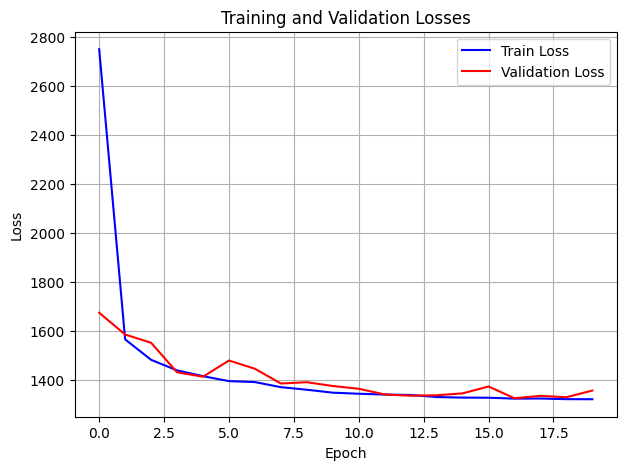

In [ ]:
# Usage example:
plot_losses(train_losses, val_losses)

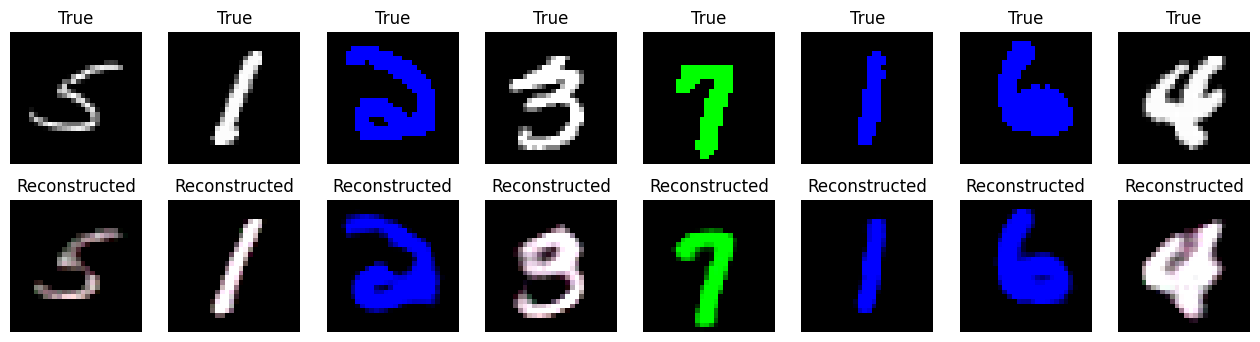

In [ ]:
# plots without either normalising or clipping the values
test_model_ae(autoencoder_mixed_mnist, test_loader)

### Everything below is irrelavant

In [ ]:
# so this is the code that I have:
# "### Load MNIST training dataset
# train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
# uncolored_X_train = train_dataset.data.numpy()
# uncolored_y_train = train_dataset.targets.numpy()

# ### Load MNIST test dataset
# test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())
# uncolored_X_test = test_dataset.data.numpy()
# uncolored_y_test = test_dataset.targets.numpy()

# ### coloured dataset
# colored_rgb_X_train = random_colorize_rgb_mnist(uncolored_X_train)
# colored_rgb_X_test = random_colorize_rgb_mnist(uncolored_X_test)

# ### labels for the dataset
# # Create labels for uncolored datasets
# uncolored_labels_train = np.zeros(len(uncolored_X_train))
# uncolored_labels_test = np.zeros(len(uncolored_X_test))

# # Create labels for colored datasets
# colored_labels_train = np.ones(len(colored_rgb_X_train))
# colored_labels_test = np.ones(len(colored_rgb_X_test))"

